# Gaussian Process Classification via Spatio-Temporal Kalman Smoothing

## Import and load data

generating some data


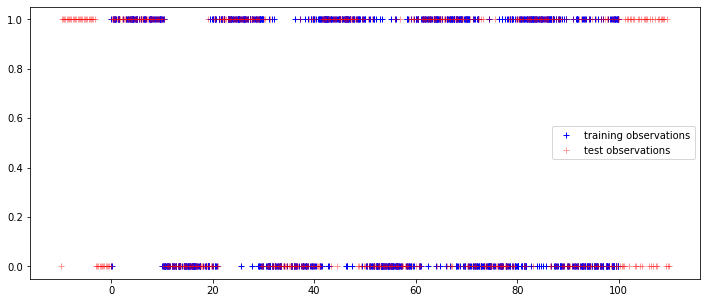

In [1]:
import sys
sys.path.insert(0, '../')
import numpy as np
from jax.experimental import optimizers
import matplotlib.pyplot as plt
import time
from sde_gp import SDEGP
import approximate_inference as approx_inf
import priors
import likelihoods
from utils import softplus_list, plot
pi = 3.141592653589793

plot_intermediate = False

print('generating some data')
np.random.seed(99)
N = 1000  # number of training points
x = 100 * np.random.rand(N)
f = lambda x_: 6 * np.sin(pi * x_ / 10.0) / (pi * x_ / 10.0 + 1)
y_ = f(x) + np.math.sqrt(0.05)*np.random.randn(x.shape[0])
y = np.sign(y_)
y[y == -1] = 0

x_test = np.linspace(np.min(x)-10.0, np.max(x)+10.0, num=500)
y_test = np.sign(f(x_test) + np.math.sqrt(0.05)*np.random.randn(x_test.shape[0]))

y_test[y_test == -1] = 0

plt.figure(1, figsize=(12, 5))
plt.plot(x, y, 'b+', label='training observations')
plt.plot(x_test, y_test, 'r+', alpha=0.4, label='test observations')
plt.legend();

## Build the GP model

In [2]:
var_f = 1.  # GP variance
len_f = 5.0  # GP lengthscale

prior = priors.Matern52(variance=var_f, lengthscale=len_f)

lik = likelihoods.Bernoulli(link='logit')
inf_method = approx_inf.ExpectationPropagation(power=0.9, intmethod='UT')
# inf_method = approx_inf.VariationalInference(intmethod='GH')
# inf_method = approx_inf.VariationalInference(intmethod='UT')
# inf_method = approx_inf.ExtendedEP(power=0)
# inf_method = approx_inf.ExtendedKalmanSmoother()
# inf_method = approx_inf.GaussHermiteKalmanSmoother()
# inf_method = approx_inf.StatisticallyLinearisedEP(intmethod='UT')
# inf_method = approx_inf.UnscentedKalmanSmoother()

model = SDEGP(prior=prior, likelihood=lik, t=x, y=y, t_test=x_test, y_test=y_test, approx_inf=inf_method)

/Users/wilkinw1/Library/Python/3.7/lib/python/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


building SDE-GP with Matern-5/2 prior and Bernoulli likelihood ...
inference method is Expectation Propagation (EP)


## Set up the optimiser

In [3]:
opt_init, opt_update, get_params = optimizers.adam(step_size=2e-1)
# parameters should be a 2-element list [param_prior, param_likelihood]
opt_state = opt_init([model.prior.hyp, model.likelihood.hyp])


def gradient_step(i, state, mod):
    params = get_params(state)
    mod.prior.hyp = params[0]
    mod.likelihood.hyp = params[1]

    # grad(Filter) + Smoother:
    neg_log_marg_lik, gradients = mod.run()
    # neg_log_marg_lik, gradients = mod.run_two_stage()  # <-- less elegant but reduces compile time

    prior_params = softplus_list(params[0])
    if (i % 10) == 0:
        print('iter %2d: var_f=%1.2f len_f=%1.2f, nlml=%2.2f' %
              (i, prior_params[0], prior_params[1], neg_log_marg_lik))

    if plot_intermediate:
        plot(mod, i)

    return opt_update(i, gradients, state)

## Optimise the hyperparameters and site parameters

In [4]:
print('optimising the hyperparameters ...')
t0 = time.time()
for j in range(200):
    opt_state = gradient_step(j, opt_state, model)
t1 = time.time()
print('optimisation time: %2.2f secs' % (t1-t0))

optimising the hyperparameters ...
iter  0: var_f=1.00 len_f=5.00, nlml=469.46
iter 10: var_f=2.50 len_f=3.62, nlml=452.80
iter 20: var_f=3.80 len_f=4.48, nlml=448.21
iter 30: var_f=4.78 len_f=5.34, nlml=446.25
iter 40: var_f=5.56 len_f=5.44, nlml=445.29
iter 50: var_f=6.19 len_f=5.41, nlml=444.81
iter 60: var_f=6.72 len_f=5.62, nlml=444.35
iter 70: var_f=7.20 len_f=5.80, nlml=443.96
iter 80: var_f=7.65 len_f=5.88, nlml=443.70
iter 90: var_f=8.07 len_f=5.96, nlml=443.47
iter 100: var_f=8.47 len_f=6.06, nlml=443.25
iter 110: var_f=8.85 len_f=6.15, nlml=443.07
iter 120: var_f=9.22 len_f=6.22, nlml=442.91
iter 130: var_f=9.58 len_f=6.29, nlml=442.76
iter 140: var_f=9.93 len_f=6.36, nlml=442.62
iter 150: var_f=10.27 len_f=6.43, nlml=442.49
iter 160: var_f=10.60 len_f=6.49, nlml=442.38
iter 170: var_f=10.92 len_f=6.55, nlml=442.27
iter 180: var_f=11.24 len_f=6.61, nlml=442.18
iter 190: var_f=11.55 len_f=6.66, nlml=442.08
optimisation time: 19.98 secs


## Make predictions

In [5]:
print('calculating the posterior predictive distribution ...')
t0 = time.time()
posterior_mean, posterior_cov, _, nlpd = model.predict()
t1 = time.time()
print('prediction time: %2.2f secs' % (t1-t0))
print('test NLPD: %1.2f' % nlpd)

calculating the posterior predictive distribution ...
prediction time: 2.00 secs
test NLPD: 0.47


## Sample from the posterior distribution

In [6]:
print('sampling from the posterior ...')
t0 = time.time()
posterior_samp = model.posterior_sample(20)
t1 = time.time()
print('sampling time: %2.2f secs' % (t1-t0))

sampling from the posterior ...
sampling time: 6.35 secs


## Plot the posterior

plotting ...


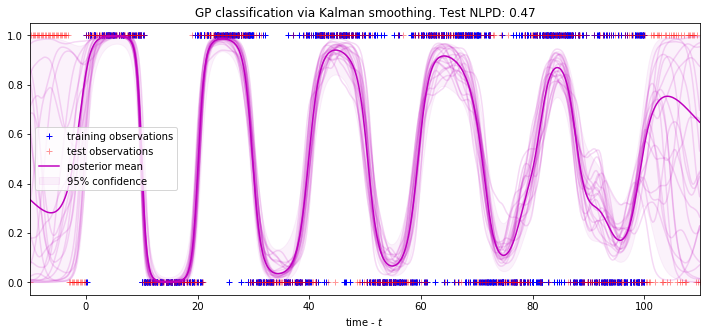

In [7]:
lb = posterior_mean[:, 0, 0] - 1.96 * posterior_cov[:, 0, 0] ** 0.5
ub = posterior_mean[:, 0, 0] + 1.96 * posterior_cov[:, 0, 0] ** 0.5
x_pred = model.t_all[:, 0]
test_id = model.test_id
t_test = model.t_all[test_id]
link_fn = model.likelihood.link_fn

print('plotting ...')
plt.figure(2, figsize=(12, 5))
plt.clf()
plt.plot(x, y, 'b+', label='training observations')
plt.plot(x_test, y_test, 'r+', alpha=0.4, label='test observations')
plt.plot(x_pred, link_fn(posterior_mean[..., 0]), 'm', label='posterior mean')
plt.fill_between(x_pred, link_fn(lb), link_fn(ub), color='m', alpha=0.05, label='95% confidence')
plt.plot(t_test, link_fn(posterior_samp[test_id, 0, :]), 'm', alpha=0.15)
plt.xlim(t_test[0], t_test[-1])
plt.legend()
plt.title('GP classification via Kalman smoothing. Test NLPD: %1.2f' % nlpd)
plt.xlabel('time - $t$');